In [3]:
import odc.stac
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pystac_client
import planetary_computer
import matplotlib.colors
import matplotlib.ticker as mticker

## Accessing Sentinel-2 data using odc-stac

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [5]:
start_date = "2025-01-01"
end_date = "2025-01-31"

eaton_bbox_gdf = gpd.read_file("/home/jovyan/WILDFIRE/Yogerej_Folder/eaton.geojson")
bbox = eaton_bbox_gdf.total_bounds
bbox


array([-118.20626495,   34.1527911 , -117.9896553 ,   34.24611503])

#### Reading in Eaton region in LA

In [6]:
search = catalog.search(
    collections=["sentinel-2-l2a"], # sentinel-2-c1-l2a if using earthsearch
    bbox=bbox,
    datetime=(start_date, end_date), 
    #query={"eo:cloud_cover": {"lt": 30}},
)

items = search.item_collection()
items

In [7]:
bands = ["B02", "B03", "B04", "B08", "B09", "B11", "B12", "SCL"]  

s2_ds = odc.stac.load(items,
                      bands=bands, 
                      #chunks={"x": 256, "y": 256},
                      resolution=10,
                      chunks={},
                      groupby='solar_day',
                      bbox=bbox,
)

s2_ds

<xarray.Dataset> Size: 340MB
Dimensions:      (y: 1058, x: 2008, time: 5)
Coordinates:
  * y            (y) float64 8kB 3.79e+06 3.79e+06 ... 3.78e+06 3.78e+06
  * x            (x) float64 16kB 3.888e+05 3.888e+05 ... 4.089e+05 4.089e+05
    spatial_ref  int32 4B 32611
  * time         (time) datetime64[ns] 40B 2025-01-02T18:37:51.024000 ... 202...
Data variables:
    B02          (time, y, x) float32 42MB dask.array<chunksize=(1, 1058, 2008), meta=np.ndarray>
    B03          (time, y, x) float32 42MB dask.array<chunksize=(1, 1058, 2008), meta=np.ndarray>
    B04          (time, y, x) float32 42MB dask.array<chunksize=(1, 1058, 2008), meta=np.ndarray>
    B08          (time, y, x) float32 42MB dask.array<chunksize=(1, 1058, 2008), meta=np.ndarray>
    B09          (time, y, x) float32 42MB dask.array<chunksize=(1, 1058, 2008), meta=np.ndarray>
    B11          (time, y, x) float32 42MB dask.array<chunksize=(1, 1058, 2008), meta=np.ndarray>
    B12          (time, y, x) float32 42MB dask.array<chunksize=(1, 1058, 2008), meta=np.ndarray>
    SCL          (time, y, x) float32 42MB dask.array<chunksize=(1, 1058, 2008), meta=np.ndarray>

## Reading in Fire Perimeter file

The fire perimeter is used to compare with the vegetation indices that is calculated later.

In [11]:
fire_perimeter = gpd.read_file(f"/home/jovyan/WILDFIRE/Fire_Incident_Analysis/Air_Perimeter_Census/fires_perimeter.geojson")
fire_perimeter = fire_perimeter.to_crs('EPSG:32611')

eaton_fire_perimeter = fire_perimeter[fire_perimeter['mission_group'] == 'Eaton']
palisade_fire_perimeter = fire_perimeter[fire_perimeter['mission_group'] == 'Palisades']

## Data Processing
### Removing cloud cover pixels

* Cloud cover is removed using Scene Classification Layer (SCL) from Sentinel-2. This results in nan pixels for cloud covers in the dataset.
* The code to removel cloud cover is obtained from GDA Demo

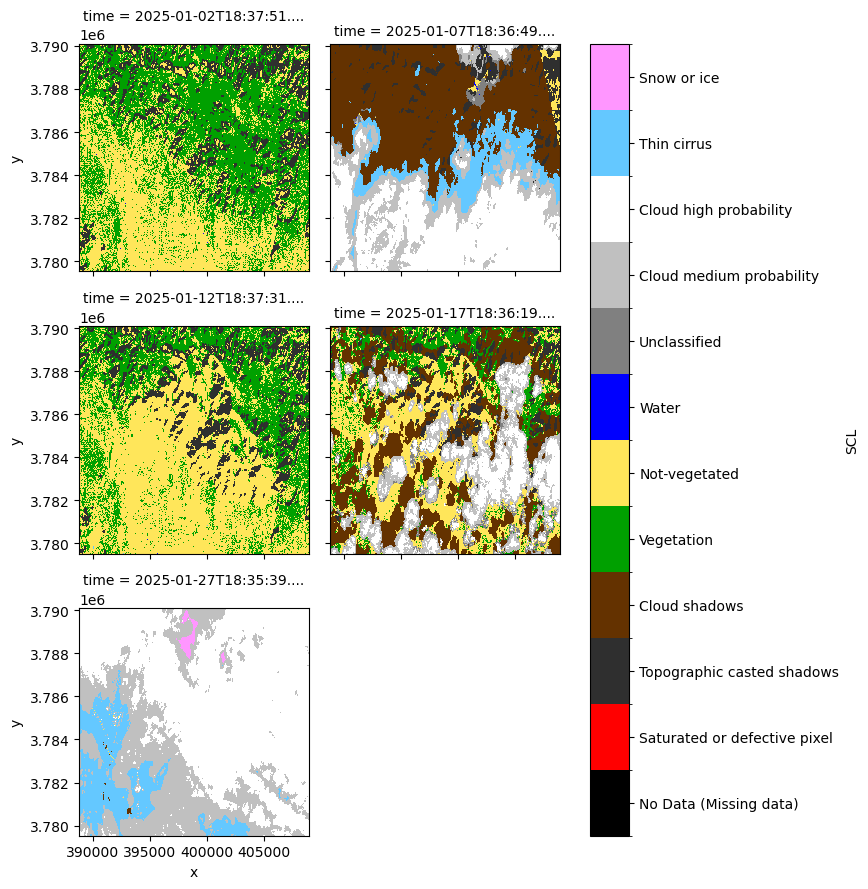

In [12]:
# here's some colormap info
scl_class_info = {
    0: {"name": "No Data (Missing data)", "color": "#000000"},
    1: {"name": "Saturated or defective pixel", "color": "#ff0000"},
    2: {
        "name": "Topographic casted shadows",
        "color": "#2f2f2f",
    },  # (called 'Dark features/Shadows' for data before 2022-01-25)
    3: {"name": "Cloud shadows", "color": "#643200"},
    4: {"name": "Vegetation", "color": "#00a000"},
    5: {"name": "Not-vegetated", "color": "#ffe65a"},
    6: {"name": "Water", "color": "#0000ff"},
    7: {"name": "Unclassified", "color": "#808080"},
    8: {"name": "Cloud medium probability", "color": "#c0c0c0"},
    9: {"name": "Cloud high probability", "color": "#ffffff"},
    10: {"name": "Thin cirrus", "color": "#64c8ff"},
    11: {"name": "Snow or ice", "color": "#ff96ff"},
}

scl_cmap = plt.cm.colors.ListedColormap([info["color"] for info in scl_class_info.values()])
class_values = sorted(list(scl_class_info.keys()))
bounds = [(class_values[i] + class_values[i + 1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, scl_cmap.N)
ticklabels = [item['name'] for item in scl_class_info.values()]

s2_ds['SCL'].plot.imshow(col='time',
                         col_wrap=2,
                         cmap=scl_cmap,
                         cbar_kwargs={"ticks": class_values, "format":mticker.FixedFormatter(ticklabels)},
                         norm=norm,
                         robust=True)

## Normalized Difference Vegetation Index (NDVI)

* NDVI is used to estimate the difference in vegetation density in the area of interest. The bands used to calculate NDVI is 8 (NIR) and 4 (Red).

In [13]:
ndvi_da = (s2_ds["B08"] - s2_ds["B04"]) / (s2_ds["B08"] + s2_ds["B04"])

In [14]:
bad_scl = [0,1,2,3,8,9,10]

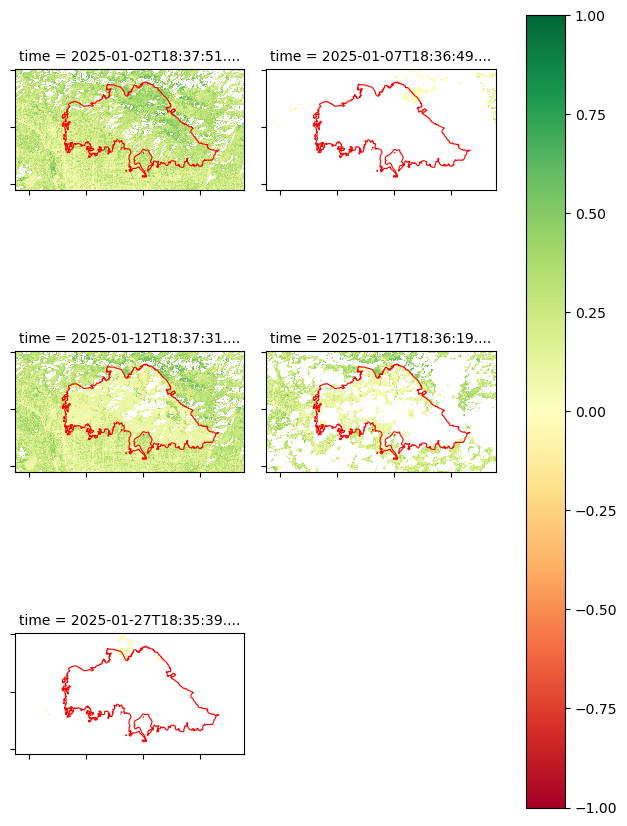

In [16]:
ndvi_masked_da = ndvi_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()
plot_ndvi = ndvi_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

for i, ax in enumerate(plot_ndvi.axes.flat):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    eaton_fire_perimeter.boundary.plot(ax=ax, edgecolor='red', linewidth=0.8)

**Green Normalized Difference Vegetation Index (GNDVI)**
* Modified version of NDVI to be more sensitive to the variation of chlorophyll content in the crop. “ The highest correlation values with leaf N content and DM were obtained with the GNDVI index in all data acquisition periods and both experimental phases. … GNDVI was more sensible than NDVI to identify different concentration rates of chlorophyll, which is highly correlated at nitrogen, in two species of plants.” ([Gitelson et al. 1996](https://www.researchgate.net/profile/Anatoly-Gitelson))

In [17]:
gndvi_da = (s2_ds["B08"] - s2_ds["B03"]) / (s2_ds["B08"] + s2_ds["B03"])

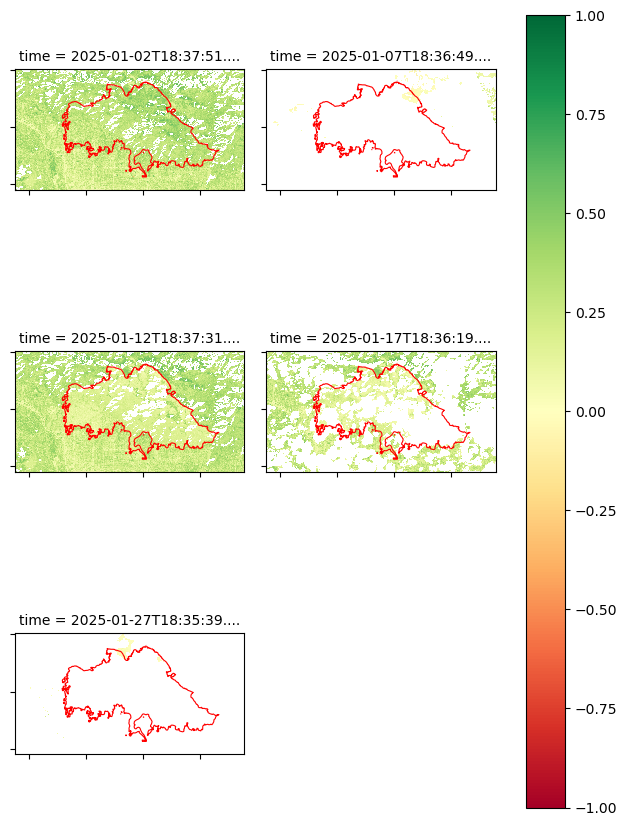

In [18]:
gndvi_masked_da = gndvi_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()
plot_gndvi = gndvi_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

for i, ax in enumerate(plot_gndvi.axes.flat):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    eaton_fire_perimeter.boundary.plot(ax=ax, edgecolor='red', linewidth=0.8)

**Enhanced Vegetation Index (EVI)**
* EVI is similar to Normalized Difference Vegetation Index (NDVI) and can be used to quantify vegetation greenness. However, EVI corrects for some atmospheric conditions and canopy background noise and is more sensitive in areas with dense vegetation. It incorporates an “L” value to adjust for canopy background, “C” values as coefficients for atmospheric resistance, and values from the blue band (B).  These enhancements allow for index calculation as a ratio between the R and NIR values, while reducing the background noise, atmospheric noise, and saturation in most cases ([USGS, 2019](https://www.usgs.gov/landsat-missions/landsat-enhanced-vegetation-index?qt-science_support_page_related_con=0#qt-science_support_page_related_con)).

In [19]:
evi_da = 2.5 * ((s2_ds["B08"] - s2_ds["B04"]) / (s2_ds["B08"] + 6 * s2_ds["B04"] - 7.5 * s2_ds["B02"] + 1)) 

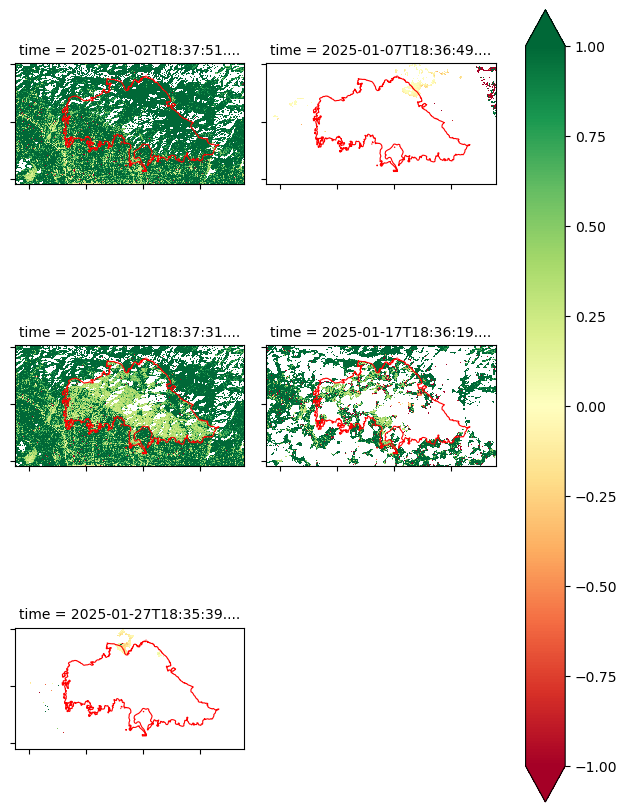

In [20]:
evi_masked_da = evi_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()
plot_evi = evi_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

for i, ax in enumerate(plot_evi.axes.flat):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    eaton_fire_perimeter.boundary.plot(ax=ax, edgecolor='red', linewidth=0.8)

In [ ]:
bad_scl = [0,1,2,3,8,9,10]
evi_masked_da = evi_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()
evi_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

**Soil Adjusted Vegetation Index (SAVI)**
* SAVI is used to correct Normalized Difference Vegetation Index (NDVI) for the influence of soil brightness in areas where vegetative cover is low. Landsat Surface Reflectance-derived SAVI is calculated as a ratio between the R and NIR values with a soil brightness correction factor (L) defined as 0.5 to accommodate most land cover types ([USGS, 2019](https://www.usgs.gov/landsat-missions/landsat-soil-adjusted-vegetation-index)).

In [22]:
savi_da = (s2_ds["B08"] - s2_ds["B04"]) / (s2_ds["B08"] + s2_ds["B04"] + 0.428) * (1.428) 

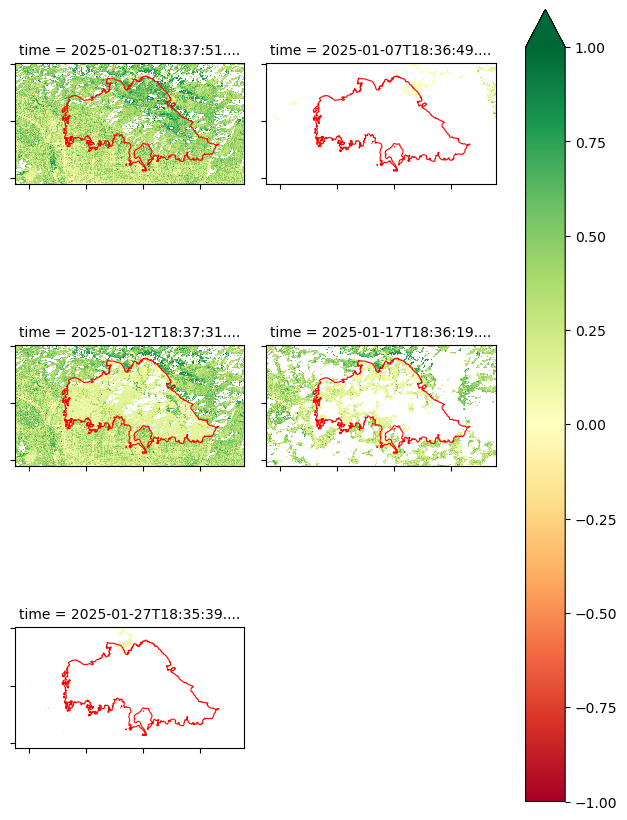

In [23]:
savi_masked_da = savi_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()
plot_savi = savi_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

for i, ax in enumerate(plot_savi.axes.flat):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    eaton_fire_perimeter.boundary.plot(ax=ax, edgecolor='red', linewidth=0.8)

**Normalized Difference Moisture Index (NDMI)** 
* NDMI is used to determine vegetation water content. It is calculated as a ratio between the NIR and SWIR values in traditional fashion ([USGS, 2019](https://www.usgs.gov/landsat-missions/normalized-difference-moisture-index)).

In [24]:
ndmi_da = (s2_ds["B08"] - s2_ds["B11"]) / (s2_ds["B08"] + s2_ds["B11"])

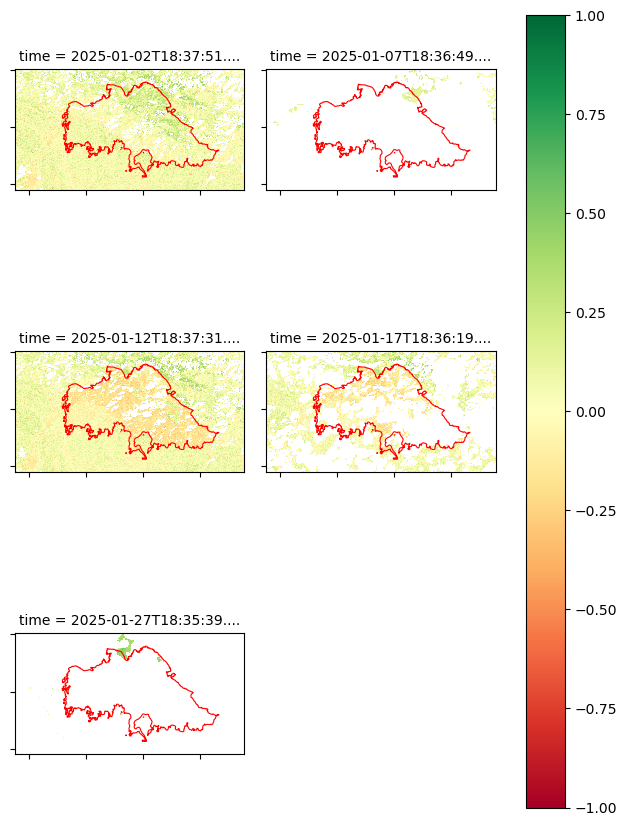

In [25]:
ndmi_masked_da = ndmi_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()
plot_ndmi = ndmi_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

for i, ax in enumerate(plot_ndmi.axes.flat):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    eaton_fire_perimeter.boundary.plot(ax=ax, edgecolor='red', linewidth=0.8)

**Moisture Stress Index (MSI)**
* Moisture Stress Index is used for canopy stress analysis, productivity prediction and biophysical modeling. Interpretation of the MSI is inverted relative to other water vegetation indices; thus, higher values of the index indicate greater plant water stress and in inference, less soil moisture content. The values of this index range from 0 to more than 3 with the common range for green vegetation being 0.2 to 2 ([Sentinel Hub](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/msi/), [GIS Crack](https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/)).

In [27]:
msi_da = s2_ds["B11"] / s2_ds["B08"]

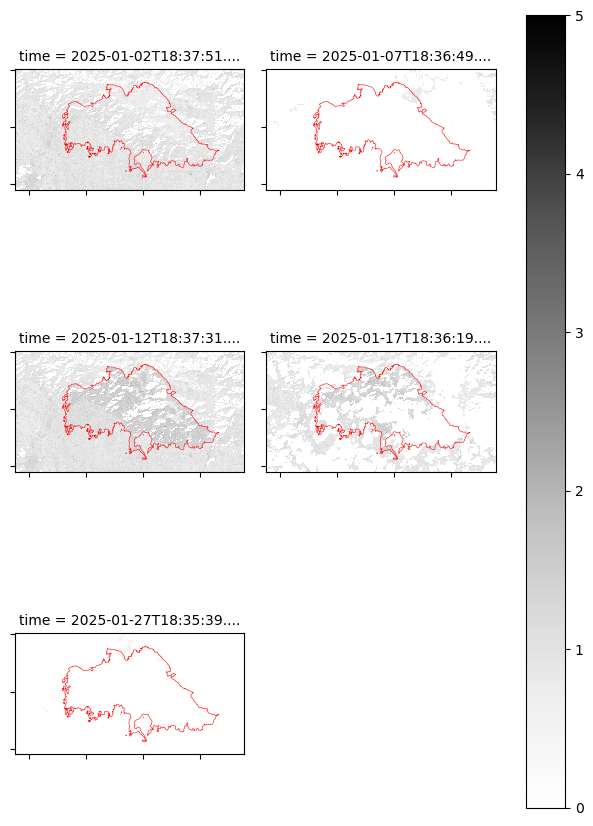

In [29]:
msi_masked_da = msi_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()
plot_msi = msi_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='Grays',vmin=0,vmax=5)

for i, ax in enumerate(plot_msi.axes.flat):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    eaton_fire_perimeter.boundary.plot(ax=ax, edgecolor='red', linewidth=0.4)

**Green Coverage Index (GCI)**
* Green Chlorophyll Index is used to estimate the content of leaf chlorophyll in various species of plants. The chlorophyll content reflects the physiological state of vegetation; it decreases in stressed plants and can therefore be used as a measurement of plant health ([EOS, 2019](https://eos.com/blog/vegetation-indices/)).

In [30]:
gci_da = (s2_ds["B09"] / s2_ds["B03"]) -1

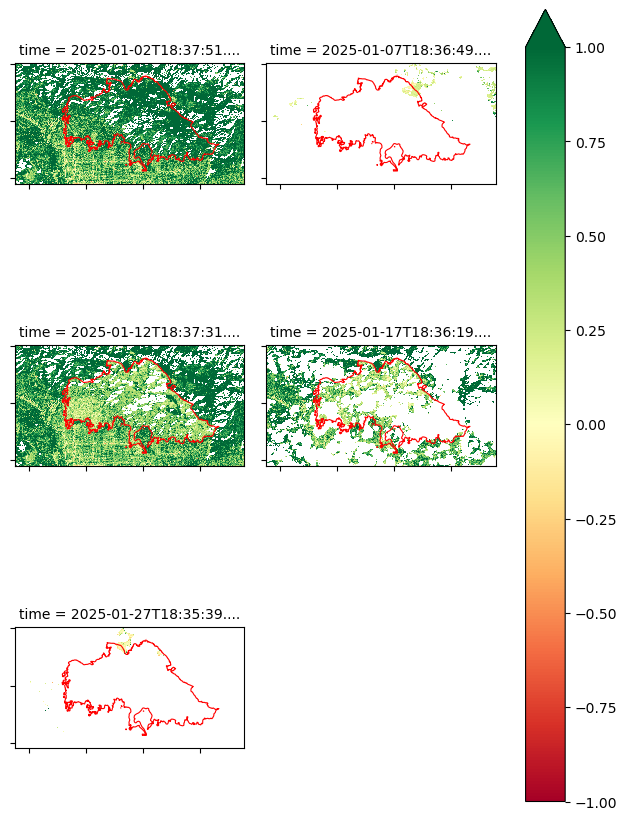

In [31]:
gci_masked_da = gci_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()
plot_gci = gci_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

for i, ax in enumerate(plot_gci.axes.flat):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    eaton_fire_perimeter.boundary.plot(ax=ax, edgecolor='red', linewidth=0.8)

**Normalized Burned Ratio Index (NBRI)**
* Forest fires are a severe manmade or natural phenomena that destroy natural recourses, live stock, unbalances the local environments, release huge amount of Green House Gases etc. NBRI takes advantage of the near infrared and short wave infrared spectral bands, which are sensitive in vegetation changes, to detect burned areas and monitor the recovery of the ecosystem ([GIS Crack](https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/)).

In [32]:
nbri_da = (s2_ds["B08"] - s2_ds["B12"]) / (s2_ds["B08"] + s2_ds["B12"])

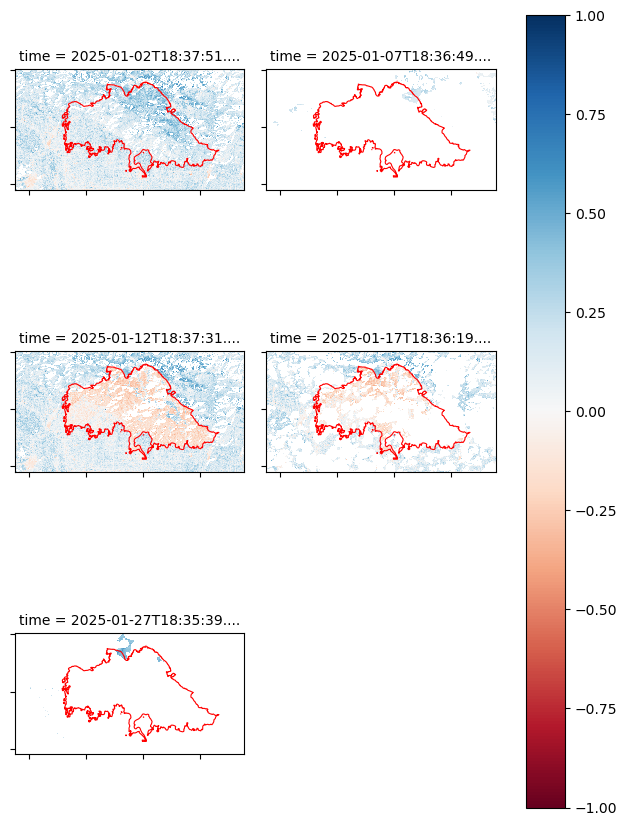

In [33]:
nbri_masked_da = nbri_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()
plot_nbri = nbri_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdBu',vmin=-1,vmax=1)

for i, ax in enumerate(plot_nbri.axes.flat):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    eaton_fire_perimeter.boundary.plot(ax=ax, edgecolor='red', linewidth=0.8)

## Creating an NBRI mask

* The NBRI mask is created to know the severity of burns by setting a threshold value.

In [34]:
mask = (nbri_masked_da != 0).compute()
filtered_nbri_da = nbri_masked_da.where(mask, drop=True)

prefire_nbri_da = filtered_nbri_da.sel(time='2025-01-02')
postfire_nbri_da = filtered_nbri_da.sel(time='2025-01-12')
delta_bri = prefire_nbri_da.squeeze() - postfire_nbri_da.squeeze()

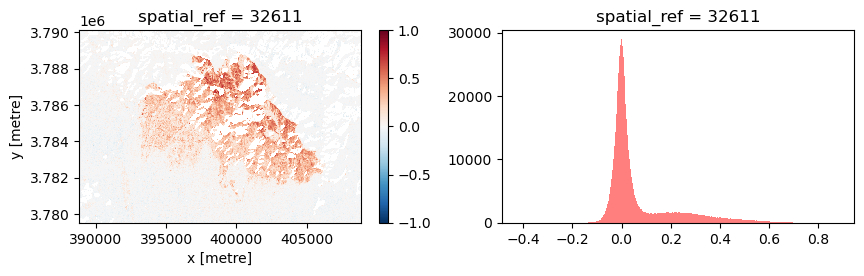

In [36]:
f, ax = plt.subplots(1,2, figsize=(10,2.5))

delta_bri.squeeze().plot.imshow(ax=ax[0], cmap='RdBu_r', vmin=-1, vmax=1, robust=True)
hist_delta_nbri = delta_bri.plot.hist(ax=ax[1], bins=1000,color='r',alpha=0.5)

#### Based on the histogram above, a threshold value of 0.2 is selected

Text(0.5, 1.0, 'NBRI mask')

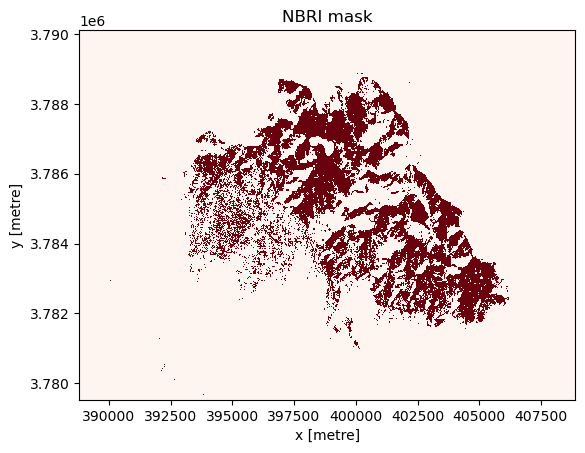

In [37]:
def mask(nbri_array, threshold=0.2):
    burnt = nbri_array > threshold
    return burnt

nbri_mask = mask(delta_bri)

f, axs = plt.subplots()
nbri_mask.plot.imshow(ax=axs, cmap='Reds', add_colorbar=False)
axs.set_title('NBRI mask')

#### Delta NBRI

* Based on the difference between NBRI on pre- and post-fire dates, the delta NBRI can be obtained.
* Delta NBRI is very useful in determing the vegetation regrowth potential after major wildfire events. It is determined according to severity values summarized in the tabl below:

[NBRI Severity values](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/calculate-dNBR-Landsat-8/)

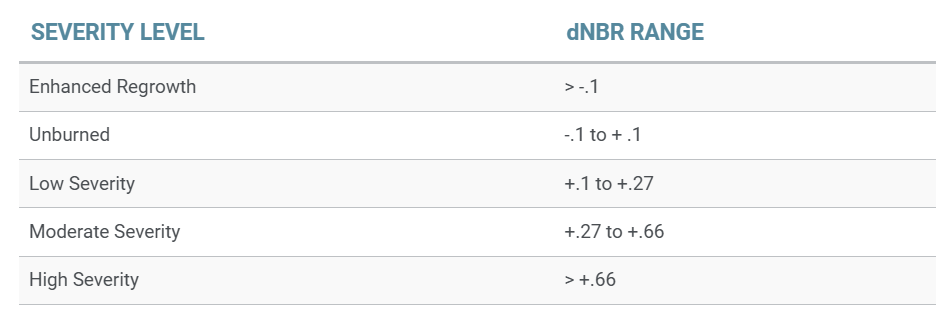

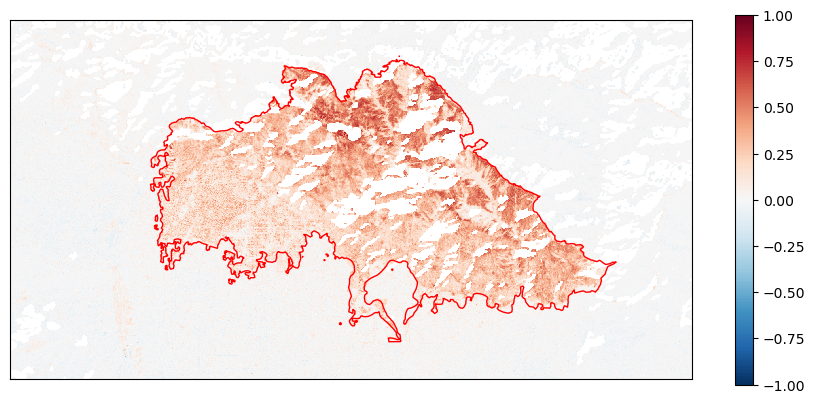

In [52]:
f,ax = plt.subplots(figsize=(11,6))

delta_bri.squeeze().plot.imshow(ax=ax, cmap='RdBu_r', vmin=-1, vmax=1, cbar_kwargs={'shrink':0.8}, robust=True)
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
 
eaton_fire_perimeter.boundary.plot(ax=ax, edgecolor='red', linewidth=1)
plt.savefig('Eaton_delta_nbri')

In [ ]:
nbri_mask.rio.resolution()

In [ ]:
total_pixels = nbri_mask.size
windowed_area = 100
pixel_area =  windowed_area / total_pixels

nbri_pixels = (nbri_mask == 1).sum().item()
burnt_area = nbri_pixels * pixel_area

percentage_burnt = (burnt_area / windowed_area) * 100

print(f"Total burnt area: {burnt_area:.2f} square kilometers")
print(f"Percentage of burnt region: {percentage_burnt:.1f} %")